# Summer project 

Note that you should have CAMB installed, which can be done by running `pip install camb`. For more information, visit https://camb.info/.

The theory is heavily inspired in the articles contained on the folder ''Papers/''

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from astropy import constants as const
import scipy.integrate as integrate

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders. Delete these two lines for pip/conda install.
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.3.6 installed at /home/vpedre/anaconda3/lib/python3.9/site-packages/camb


## Getting familiar with CAMB

### Basic functions

In [3]:
pars = model.CAMBparams()  # Set of parameters created

# Some parameters were set as showed in the demo
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022
 omch2 = 0.122
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.5
 TCMB = 2.7255
 YHe = 0.24524332588411976
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 

In [4]:
camb.get_age(pars)  # age of the universe for given set of parameters

13.74073863845039

In [57]:
results = camb.get_results(pars)

# neutino is for massles and nu for massive neutrinos
var = ['K', 'cdm', 'baryon', 'photon', 'neutrino' , 'nu', 'de']
Om_tot = 0

for v in var:
    Om_tot += results.get_Omega(v)

Om_tot

1.0

## Cosmological parameters from Planck

From [Planck Collaboration (2018)](https://arxiv.org/pdf/1807.06209.pdf) Table 1, ''Combined'' column.
Something worth remembering

$$\sum_i^n \Omega_i(z) + \Omega_K(z) = 1$$

In [58]:
pars = model.CAMBparams()  # Set of parameters created

pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
pars.set_cosmology(H0=67.4, ombh2=0.02233, omch2=0.1198, omk=0, tau=0.054)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02233
 omch2 = 0.1198
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.4
 TCMB = 2.7255
 YHe = 0.24538288182613635
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun

In [62]:
results = camb.get_results(pars)

omde = results.get_Omega('de')
omk = pars.omk
omm = 1 - omde - omk

## Defining Background Quantities $E(z)\,\, \&\,\, D(z)$

In the context of GR, cosmic acceleration requires a fluid, dubbed **Dark Energy** (DE), with an equation of state $w_{DE} < -1/3$. The standard model of csomology, commonly refered to as the $\Lambda CDM$ model, assumes that this phenomenon is due to the presence of a cosmological constant $\Lambda$ described by a constant equation state $w_{\Lambda} = -1$, which corresponds to a time-independent energy density. This has some problems (*cosmological constant problem* and *coincidence problem*), so a more general scenario for the component responsible for cosmic acceleration postulates a dynamical DE, with a dependent equation of state parameter $w_{DE}(z)$.
$$w_{DE}(z) = w_0 + w_a\frac{z}{1+z}$$
Where $w_0$ is  the present value of the equation of state and $w_a$ is a measure of its variation. The evolution of the DE density obeys
$$\rho_{DE} (z) = \rho_{DE,0} (1+z)^{3(1+w_0+w_a)}exp\left[-3w_a\frac{z}{1+z}\right] $$

Then, we can get
$$E(z) = \sqrt{
    \Omega_{m,0}(1+z)^3 + \Omega_{DE,0}(1+z)^{3(1+w_0+w_a)}exp\left[-3w_a\frac{z}{1+z}\right] + \Omega_{K,0}(1+z)^2
}$$
With the current DE density $\Omega_{DE,0}$ satisfying the relation $\Omega_{DE,0} = 1 - \Omega_{m,0} - \Omega_{K, 0}$. The $\Lambda CDM$ model can be recovered by setting $w_0=-1$ and $w_a=0$, in which case

$$E(z) = \sqrt{
    \Omega_{m,0}(1+z)^3 + \Omega_{\Lambda,0} + \Omega_{K,0}(1+z)^2
}$$

In [29]:
def E(z, Omm=omm, Omde=omde, OmK=omk, w_0=pars.DarkEnergy.w, w_a=pars.DarkEnergy.wa):
    bar = Omm * (1 + z) ** 3
    de = Omde * (1 + z) ** (3 * (1 + w_0 + w_a)) * np.exp(-3 * w_a * z / (1 + z))
    cur = OmK * (1 + z) ** 2
    return np.sqrt(bar + de + cur)

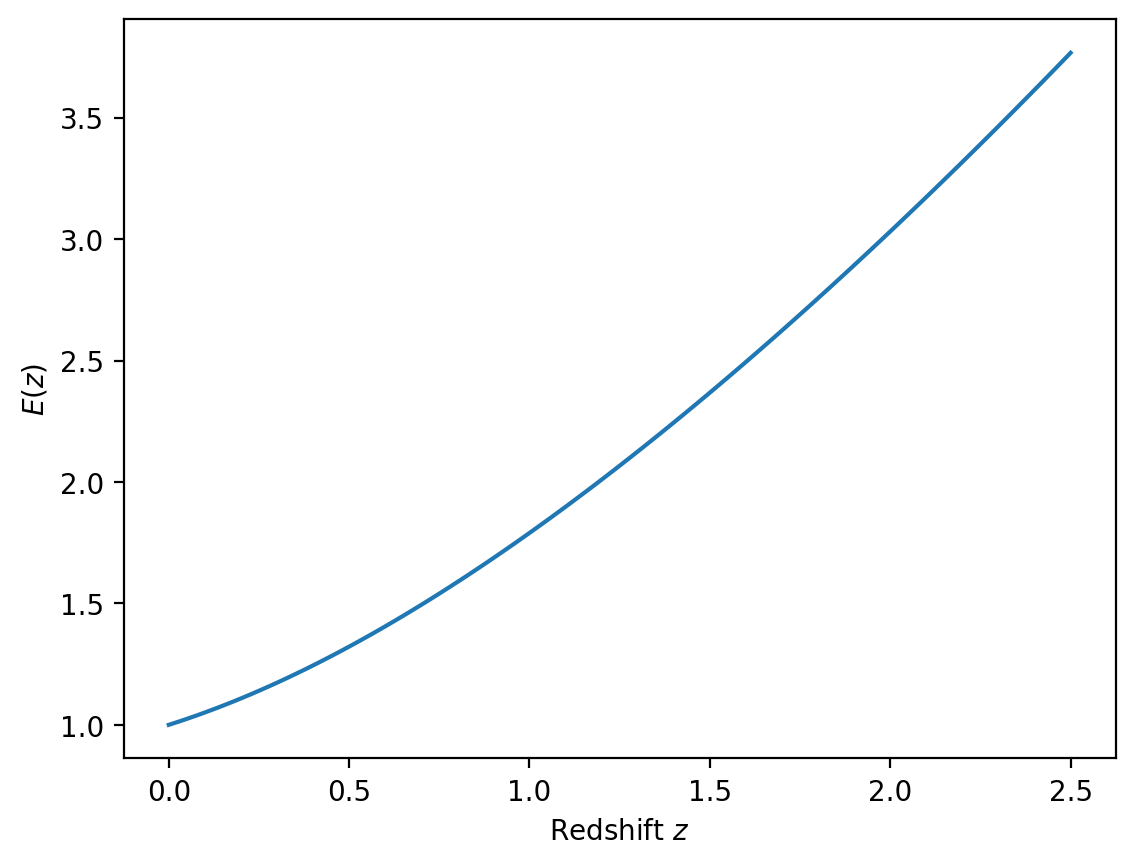

In [64]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()

ax.plot(z_to_plot, E(z_to_plot))
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$E(z)$');
# ax.set_title('');

### Distance measurments

#### Comoving distance

In [77]:
def r(z):
    """Comoving Distance as a function of the redshift
    The E(z) function defined previously is needed.
    Quad integration from scipy is used.
    ===================================================
    Input: redshift z
    Output: comoving distance r
    """
    def integrand(u):
        return 1/E(u)
    integral = integrate.quad(integrand, 0, z)[0]
    return const.c.value / pars.H0 * integral

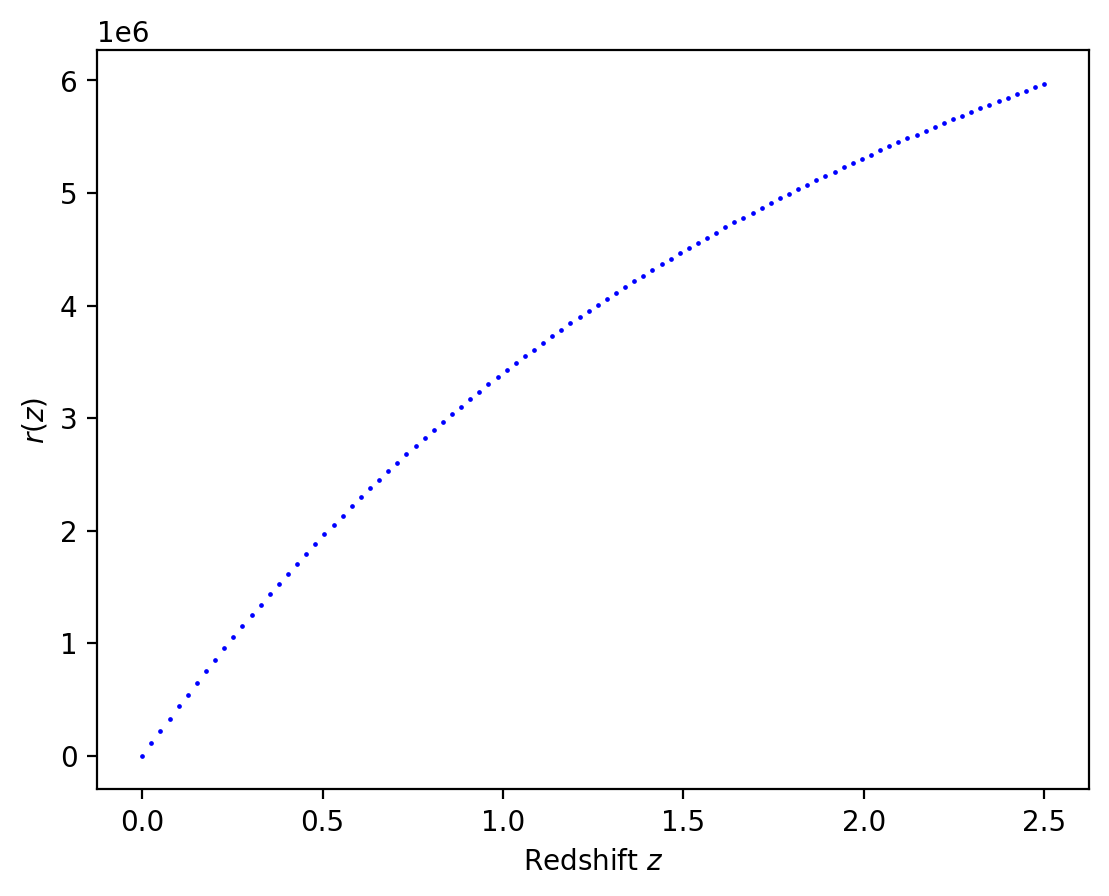

In [82]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()
for z in z_to_plot:
    ax.scatter(z, r(z), c='b', s=0.5)
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$r(z)$');
# ax.set_title('');

In [86]:
def D_A(z, Omk=omk):
    """Angular diameter distance as a function of the redshift.
    The comoving distance is needed as defined previously.
    Note that there are different definitions for different
    space-time curvatures.
    ===================================================
    Inputs: redshift z; curvature density Omk, default given by camb (optional)
    Outputs: angular diameter distance D_A
    """
    if Omk == 0:
        return r(z) / (1 + z)
    
    arg = np.sqrt(np.abs(Omk)) * pars.H0 / const.c.value * r(z)
    prop_const = const.c.value / pars.H0 / np.sqrt(np.abs(Omk))
    
    if Omk < 0:
        return prop_const / (1 + z) * np.sin(arg)

    else:
        return prop_const / (1 + z) * np.sinh(arg)


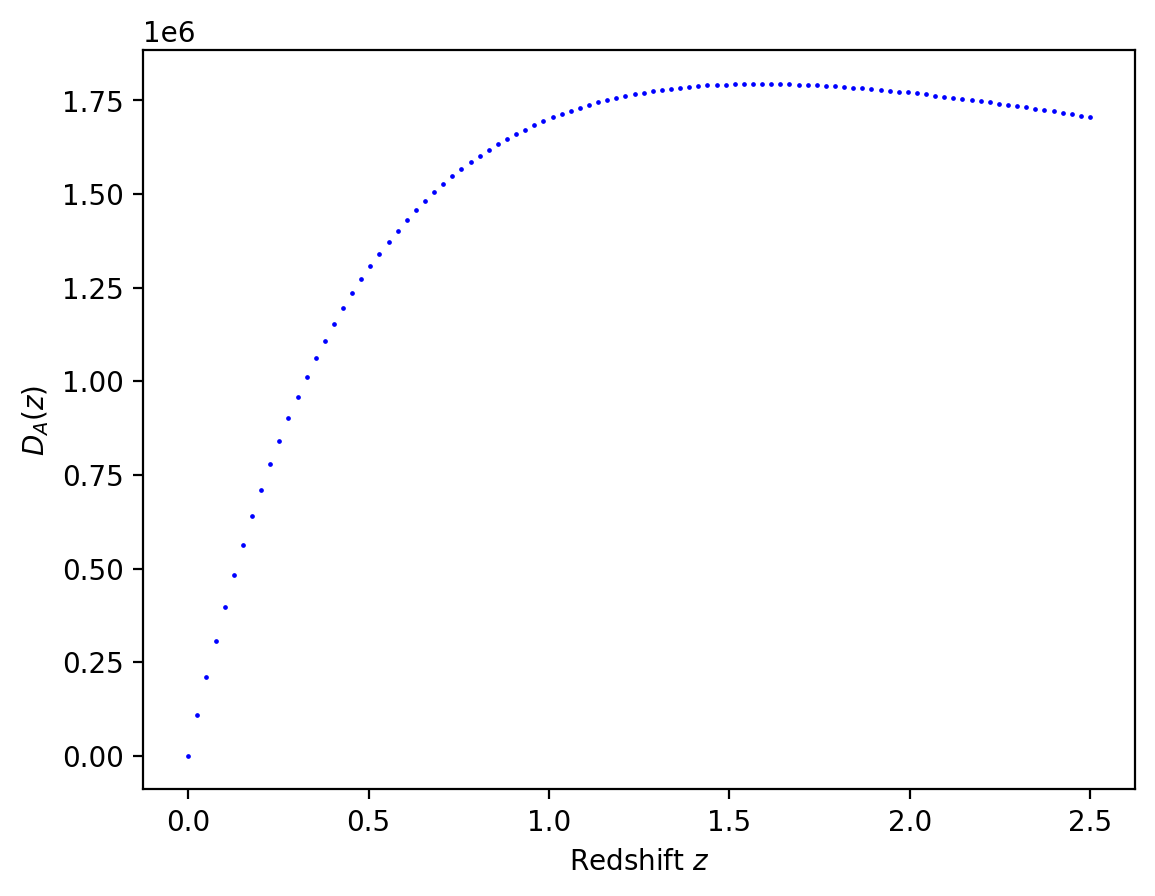

In [87]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()
for z in z_to_plot:
    ax.scatter(z, D_A(z), c='b', s=0.5)
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$D_A(z)$');
# ax.set_title('');